In [3]:
import bliss.datasets.galsim_galaxies as galaxies
import os

In [8]:
os.chdir("../..")

['temp',
 'conftest.py',
 'pytest.ini',
 '.pre-commit-config.yaml',
 'README.md',
 '.vscode',
 'bliss',
 '.codecov.yml',
 'poetry.lock',
 'lightning_logs',
 'models',
 'pyproject.toml',
 '.git',
 '.gitignore',
 '.gitattributes',
 'outputs',
 'tests',
 '.pylintrc',
 '__pycache__',
 'docs',
 '.pytest_cache',
 '.github',
 'case_studies',
 'config',
 'data']

In [40]:
g = galaxies.SDSSGalaxies({"bands": [2]}, slen=64)

In [41]:
g

In [42]:
im = g[0]

In [43]:
im.shape

AttributeError: 'dict' object has no attribute 'shape'

In [44]:
im['images'].shape

torch.Size([1, 64, 64])

In [45]:
from matplotlib import pyplot as plt

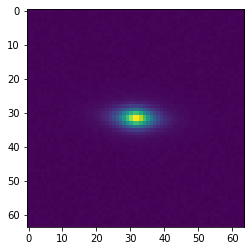

In [46]:
plt.imshow(im['images'][0])

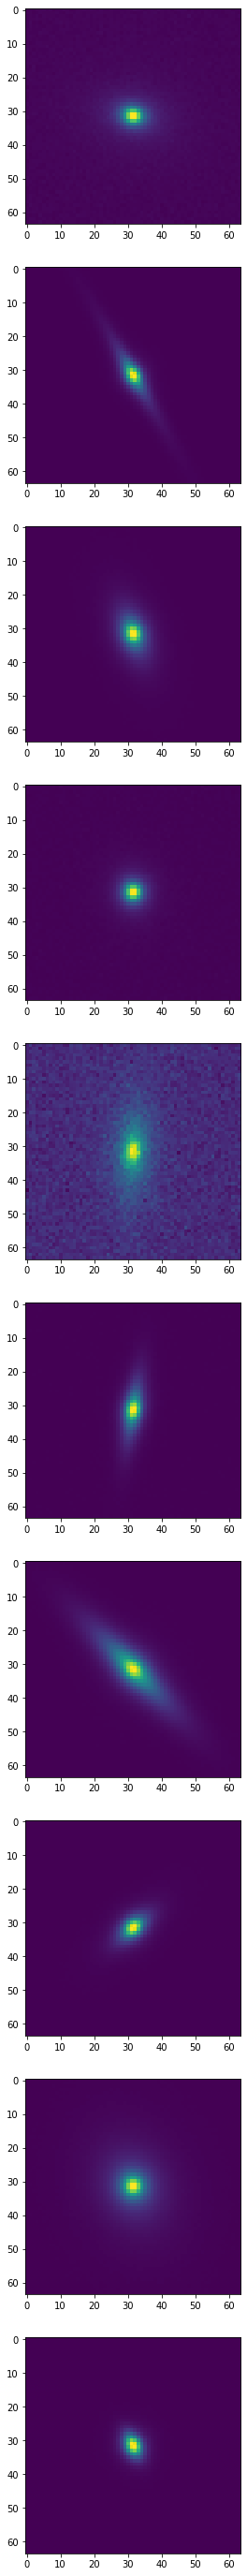

In [60]:
fig, axes = plt.subplots(10, figsize=(5, 50))
for ax in axes:
    ax.imshow(g[2]["images"][0])

In [172]:
import torch
import pytorch_lightning as pl
import numpy as np
import torch.nn.functional as F
from torch import nn

In [165]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_ch, out_ch, *args, **kwargs):
        super().__init__(
            nn.Conv2d(in_ch, out_ch, *args, **kwargs),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        
class ConvTBlock(nn.Sequential):
    def __init__(self, in_ch, out_ch, *args, **kwargs):
        super().__init__(
            nn.ConvTranspose2d(in_ch, out_ch, *args, **kwargs),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
    


class GalaxyAutoencoder(pl.LightningModule):
    def __init__(self, slen=64, start_channels=1):
        super().__init__()
        #self.n_layers = int(np.log2(slen))
        self.n_layers=5
        
        down_layers = []
        up_layers = []
        for i in range(self.n_layers):
            down_layers.append(ConvBlock(
                start_channels * (2**i), 
                start_channels * (2**(i+1)),
                (3,3),
                2,
                1
            ))
            up_layers.append(ConvTBlock(
                start_channels * (2**(i+1)),
                start_channels * (2**i), 
                (3,3),
                2,
                1,
                output_padding=1
            ))
        self.encoder = nn.Sequential(*down_layers)
        self.decoder = nn.Sequential(*up_layers[::-1])
        
        self.loss = nn.MSELoss()
        
    def forward(self, X):
        Z = self.encoder(X)
        #print(Z.shape)
        X_prime = self.decoder(Z)
        #print(X_prime.shape)
        return X_prime
    
    def training_step(self, batch, batch_idx):
        X = batch["images"]
        X_prime = self.forward(X)
        return F.mse_loss(X, X_prime).mean()
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer       

In [166]:
train_loader = g.train_dataloader()
train_loader

In [167]:
trainer = pl.Trainer(gpus='7', max_epochs=100)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [168]:
model = GalaxyAutoencoder(slen=64)

In [173]:
trainer.fit(model, train_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 6.3 K 
1 | decoder | Sequential | 6.2 K 
2 | loss    | MSELoss    | 0     
---------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.050     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/home/dereklh/.cache/pypoetry/virtualenvs/bliss-FSmgvuKM-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


In [170]:
train_loader

In [95]:
train_loader[0]

TypeError: 'DataLoader' object is not subscriptable

In [169]:
model

GalaxyAutoencoder(
  (encoder): Sequential(
    (0): ConvBlock(
      (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ConvBlock(
      (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): ConvBlock(
      (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): ConvBlock(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvBlock(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2